<a href="https://colab.research.google.com/github/ryantuckman/Machine-Learning/blob/main/tensorflow_gluon_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Overview**

We will be working with the [Gluon dataset](https://github.com/rabah-khalek/TF_tutorials/tree/master/PseudoData). A gluon is an elementary particle which gives rise to the strong force, which is the force responsible for binding together the protons and neutrons together in atomic nuclei.

The gluon is exchanged by other elementary particles in the proton and neutron called quarks. These quarks and gluons are more generally referred to as "partons".

Because of certain physical properties governing the partons, they cannot be observed by expermiments as free particles, and their distribution within the proton and neutron cannot be calculated analytically. Instead, their distribution must be inferred from data collected by high energy particle colliders like the Large Hadron Collider (LHC) at CERN.

A fast-moving proton can be described by the parton distribution function (PDF) $f(x)$, which gives the probability density of finding a parton of type $f$ (a specific quark type or gluon) carrying a fraction $x$ of the proton momentum. 

The pseudodata used in this tutorial is generated from a gluon distribution function $g(x)$, which was determined in an analysis by the [NNPDF collaboration](http://nnpdf.mi.infn.it), aiming to extract the structure of the proton using contemporary machine learning methods. More specifically, NNPDF determines PDFs using neural networks as a minimally biased modeling tool, trained using Genetic Algorithms (and more recently stochastic gradient descent). 

We will consider this pseudodata to be the *truth* that we're trying to *discover*. What we will actually fit is the *smeared truth*, where Gaussian noise is added to simulate more realistic data.

## **Importing the Gluon data set with Pandas**

There are four separate datasets each containing a total of 1000 gluon PDF predictions computed between $x=[x_{min},1]$; where:
- $x_{min} = 10^{-3}$ for `filename1`
- $x_{min} = 10^{-4}$ for `filename2`
- $x_{min} = 10^{-5}$ for `filename3`
- $x_{min} = 10^{-6}$ for `filename4`
  
Below we use Pandas to import all datapoints from text files. We then use `sklearn` to split the data randomly into 800 points for training and 200 points for testing. 

In [1]:
# Import relevant python modules
import sys, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# The datasets needed are computed by the `ComputeGluon.py` script in PseudoData
filename1='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat' 
filename2='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat' 
filename3='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat' 
filename4='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat' 

# Headers to skip
lines_to_skip = 5

# Defining the columns (cv = central value, sd = standard deviation)
columns=["x", "gluon_cv", "gluon_sd"]

# Loading data from txt file
# Change filename1 to another filename for data that extends to lower x 
# (see exercises at the bottom of this notebook)
df = pd.read_csv(filename1, 
                 sep="\s+", 
                 skiprows=lines_to_skip, 
                 usecols=[0,1,2], 
                 names=columns)

# Splitting data randomly to train and test using the sklearn library
df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

# Sort the split data according to their x values
df_train = df_train.sort_values("x")
df_test = df_test.sort_values("x")

print("Data parsing is done!")

Data parsing is done!


In [3]:
print(df_train)

            x  gluon_cv  gluon_sd
0    0.001000  4.480675  0.523964
1    0.001007  4.478519  0.520743
2    0.001014  4.476361  0.517539
3    0.001021  4.474202  0.514349
4    0.001028  4.472040  0.511176
..        ...       ...       ...
993  0.952796 -0.001109  0.003990
994  0.959401 -0.000878  0.003423
996  0.972747 -0.000634  0.002707
997  0.979490 -0.000494  0.002179
999  0.993116 -0.000144  0.000697

[800 rows x 3 columns]


## **Why do we scale the input of a Neural Network?**

Given the use of small weights in the model and the use of error between predictions and expected values, the scale of inputs and outputs used to train the model are an important factor. Unscaled input variables can result in a slow or unstable learning process, whereas unscaled target variables on regression problems can result in exploding gradients causing the learning process to fail.

The input variables are those that the network takes on the input or visible layer in order to make a prediction. In this case we simply have one input variable: x.

A good rule of thumb is that input variables should be small values, probably in the range of 0 to 1 or standardized with a zero mean and a standard deviation of one.

Whether input variables require scaling depends on the specifics of your problem and of each variable. In principle, since the x values we consider here already range from 0 to 1, we most likely do not need to scale the neural network input. For learning purposes, we will do it anyway.

In [4]:
# Import relevant python modules
from sklearn.preprocessing import StandardScaler

#Shaping the x values for the scaler
train_inputs = df_train['x'].to_numpy().reshape((-1,1))
test_inputs = df_test['x'].to_numpy().reshape((-1,1))

#Scaling input features to help the minimizer
train_scaler = StandardScaler()
train_scaler.fit(train_inputs)
test_scaler = StandardScaler()
test_scaler.fit(test_inputs)

StandardScaler()

## **Building a Neural Network using TensorFlow**

The idea here is to fit the gluon distribution (which cannot be calculated analytically) using a neural network.

We will build the neural network of 1 input, 1 hidden layer, and 1 output in two ways:
- By using the high-level Keras API (TF_Model)
- By constructing a custom NN (USER_Model)

We consider a single layered neural network to be sufficient for our exercise here, but feel free to experiment with *deeper* architectures.

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

##################################################################
# Building NN from the Keras API (layers.Dense)
##################################################################

class TF_Model(keras.Model):
    
    def __init__(self,n_features,n_neurons,n_outputs,name=None):
        
        super(TF_Model, self).__init__(name=name)
        #tf.random.set_seed(42) # Set seed for parameter initialization
        
        # Hidden layer 1
        self.hidden1 = layers.Dense(n_neurons, activation='sigmoid',input_shape=[n_features])
        # Output layer
        self.output1 = layers.Dense(n_outputs)

    def __call__(self, x):
        
        # Evaluate hidden layer
        x = self.hidden1(x)
        # Evaluate and return output
        return self.output1(x)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 

##################################################################
# Building NN from the PyTorch API (nn.Linear)
##################################################################

class Torch_Model(nn.Module):
    
    def __init__(self, n_features, n_neurons, n_outputs):

        super(Torch_Model, self).__init__()
        
        self.fc1 = nn.Linear(n_features, n_neurons) # Hidden Layer 1
        self.sig1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_neurons, n_outputs) # Output Layer

    # Evaluates and returns output
    def forward(self, x):
        out = self.fc1(x)
        out = self.sig1(out)
        out = self.fc2(out)
        return out

In [7]:
##################################################################
# Building a custom NN layer class
# self.w = weights
# self.b = biases
##################################################################

class NN_Layer(keras.Model):
    
    def __init__(self, n_inputs, n_outputs):
        
        super().__init__()
        #tf.random.set_seed(42) # Set seed for parameter initialization
        
        # Initialize weights and biases
        # A truncated normal is used to prevent large starting weights, slowing down training
        self.w = tf.Variable(tf.random.truncated_normal([n_inputs, n_outputs]), name='w')
        self.b = tf.Variable(tf.zeros([n_outputs]), name='b')
        
    def __call__(self, x):
    
        # Compute and return the output of NN layer
        y = tf.matmul(x, self.w) + self.b
        
        return y

##################################################################
# Defining our model from custom NN layers
##################################################################
class USER_Model(keras.Model):
    
    def __init__(self,n_features,n_hidden,n_outputs, name=None):
        super(USER_Model, self).__init__(name=name)
        
        # Build hidden layer
        self.hidden1 = NN_Layer(n_features,n_hidden)
        # Build output layer
        self.output1 = NN_Layer(n_hidden,n_outputs)

    def __call__(self, x):
        
        # Evaluate hidden layer
        x = self.hidden1(x)
        # Activate hidden layer
        x = tf.nn.sigmoid(x)
        # Return output
        return self.output1(x)

## **Data modeling and fitting**


The next few cells contain the bulk of the minimization routine.


### **Chi-square**

One of the most frequently occurring problems in high-energy physics is to compare an observed distribution with a prediction, for example from a simulation. Indeed, an analysis might be designed to extract some physical parameter from the simulation or prediction which best fits the data.  

For data points with Gaussian errors, the likelihood of a gaussian distribution is:

$$ L = \prod_i \frac{1}{\sqrt(2\pi\sigma^2)} e^{-\frac{(m_i - d_i)^2}{2\sigma_i^2}}$$

hence the following [MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (maximum (log) likelihood estimation) gives:

$$ \chi^2 = \sum_i^N \left(\frac{m_i - d_i}{\sigma_i} \right)^2$$

where $m_i$ is the model evaluated at point $x_i$, $d_i$ is the data, and $\sigma_i$ is the uncertainty on the data at this point.

The chi-square expresses the deviation of the observed data from the fit, weighted inversely by the uncertainties in the individual points. The chi-square can be either used to test how well a particular model describes the data or, if the prediction is a function of some parameters then the optimal values of the parameters can be found by minimizing the chi-square.

The main pitfall here is that the purely Gaussian case is in fact rather rare, usually because the data points come from Poisson-distributed numbers of events which are not well approximated by Gaussian distributions. Using a standard chi-square approach in such cases leads to biased estimates of both the parameters and their uncertainties.

Nevertheless we will assume here that our datapoints' errors are Gaussian, and we will use the chi-square as the loss function in this tutorial.

## **Prepare Data**

In [8]:
# Number of training instances
N_train = len(df_train["x"])
# Number of test instances
N_test = len(df_test["x"])

# Scale training inputs
train_x = np.array(train_scaler.transform(train_inputs)).reshape(N_train,1)
# Convert training inputs to tensor
train_x = tf.convert_to_tensor(train_x,dtype='float32')

# Gather data labels (i.e. measurements)
train_y = np.array(df_train["gluon_cv"]).reshape(N_train,1)
# Gather data uncertainties 
train_sigma = np.array(df_train["gluon_sd"]).reshape(N_train,1)
# Add noise to data
np.random.seed(42)
train_y += np.random.normal(0, train_sigma)
# Convert data and uncertainties to tensors
train_y = tf.convert_to_tensor(train_y,dtype='float32')
train_sigma = tf.convert_to_tensor(train_sigma,dtype='float32')

# Do the same procedure as above with test set
test_x = np.array(test_scaler.transform(test_inputs)).reshape(N_test,1)
test_y = np.array(df_test["gluon_cv"]).reshape(N_test,1)
test_sigma = np.array(df_test["gluon_sd"]).reshape(N_test,1)
test_y += np.random.normal(0, test_sigma)
test_x = tf.convert_to_tensor(test_x,dtype='float32')
test_y = tf.convert_to_tensor(test_y,dtype='float32')
test_sigma = tf.convert_to_tensor(test_sigma,dtype='float32')

## **Prepare Model**

In [9]:
# Number of neurons in input layer (= number of features = 1, which is momentum fraction x)
N_features = 1
# Number of neurons in hidden layer
N_hidden = 5
# Number of neurons in output layer
N_output = 1

# Initialize model
model = TF_Model(N_features,N_hidden,N_output,name='my_TF_model')
#model = USER_Model(N_features,N_hidden,N_output,name='my_custom_model')

# User-defined loss function (chi-squared)
def loss_function(predictions,labels,label_errors):
    return tf.reduce_sum(tf.math.square((labels-predictions)/label_errors))

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Define tensorflow function for training step (computing and applying gradients)
@tf.function
def train_step(inputs, labels, label_errors):
    
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_function(predictions,labels,label_errors)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss
    
# Define tensorflow function for computing loss
@tf.function
def compute_loss(inputs, labels, label_errors):
    
    predictions = model(inputs)
    loss = loss_function(predictions,labels,label_errors)
    
    return loss

## **Plotting script**

In [10]:
def plot():
  %matplotlib inline
  # Plot results
  fig = plt.figure(figsize=(15,10))
  ax = plt.subplot(111)
  ax.plot(df_train["x"],df_train["gluon_cv"],color='darkblue',label='$t_{g}^{train}$', lw=3)
  #ax.plot(df_test["x"],df_test["gluon_cv"],color='darkgreen',label='$t_{g}^{test}$',alpha=0.3)

  #ax.scatter(df_train["x"],train_y.numpy(), marker="o", color='darkblue',alpha=1.,label='$d_{g}^{train}$')
  #ax.scatter(df_test["x"],test_y.numpy(),marker="o",  color = 'darkgreen',alpha=1.,label='$d_{g}^{test}$')

  ax.errorbar(df_train["x"],train_y.numpy(),yerr=train_sigma.numpy(),fmt='.',color='darkblue',label='$d_{g}^{train}$',alpha=0.3)
  #ax.errorbar(df_test["x"],test_y.numpy(),yerr=test_sigma.numpy(),fmt='.',color='darkgreen',label='$d_{g}^{test}$',alpha=0.5)

  ax.plot(df_train["x"],prediction_values.numpy(),color='red',label='$NN_{g}$', lw=3)
  ax.fill_between(df_train["x"],df_train["gluon_cv"]+df_train["gluon_sd"],
                  df_train["gluon_cv"]-df_train["gluon_sd"] ,color='blue', 
                  alpha=0.1, label='$\sigma_{g}$')

  #df_train.plot(kind='line',x='x',y=['gluon_cv'], yerr='gluon_sd',color=['red'], ax=ax)

  ax.text(0.1,0.3,r'Epoch = %d'%(epoch),fontsize=20,transform=ax.transAxes)
  ax.text(0.1,0.2,r'$\chi^2_{\rm training}/N_{\rm data} = %.2f$'%(training_chi2),fontsize=20,transform=ax.transAxes)
  ax.text(0.1,0.1,r'$\chi^2_{\rm test}/N_{\rm data} = %.2f$'%(test_chi2),fontsize=20,transform=ax.transAxes)

  # Plot settings
  ax.set_xscale('log')
  ax.set_ylabel(r'$g(x)$',fontsize=45)
  ax.set_xlabel(r'$x$',fontsize=45)
  ax.legend(loc='best',fontsize=30,frameon=False)
  ax.tick_params(which='both',direction='in',labelsize=30)
  ax.tick_params(which='major',length=10)
  ax.tick_params(which='minor',length=5)
  plt.tight_layout()
  display.clear_output(wait=True)
  display.display(plt.gcf())


## **Train and Plot Neural Network**

- $t_{g}^{train}$ represents the truth value of the training set, i.e the values taken from the txt file.
- $d_{g}^{train}$ are the smeared data we actually fit.
- $NN_{g}$ is the output of our Neural Network.

You can uncomment several other information like: $d_{g}^{test}$, the error bars used, etc.

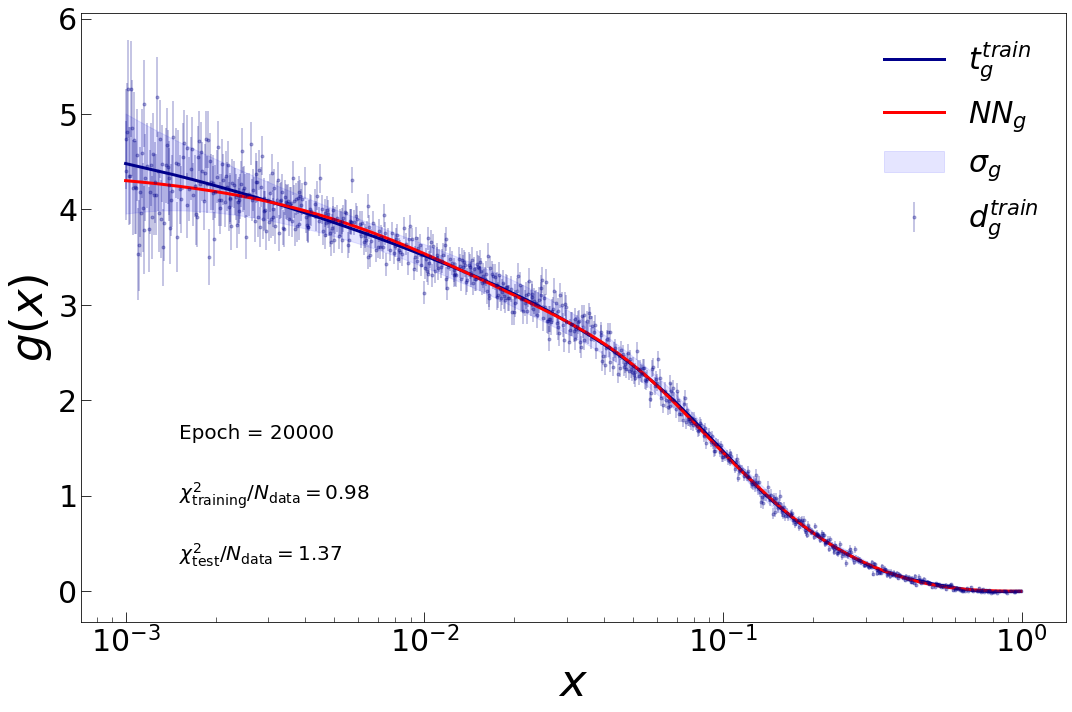

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython import display
import time
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Number of training epochs
training_epochs = 20000
# Epoch intervals to print
epoch_it = 1000

VERBOSITY=False #choose True to plot the NN every iteration

for epoch in range(training_epochs+1):
    
    train_loss = train_step(train_x, train_y, train_sigma)
    test_loss = compute_loss(test_x, test_y, test_sigma)
    
    template = 'Epoch {:d}, Chi2/Npts: {:.2f}, Test Chi2/Npts: {:.2f}'
    if epoch%epoch_it==0:

        # Compute predictions and chi2 with latest model parameters
        prediction_values = model(train_x)
        training_chi2 = loss_function(prediction_values,train_y,train_sigma).numpy()/N_train
        test_prediction_values = model(test_x)
        test_chi2 = loss_function(test_prediction_values,test_y,test_sigma).numpy()/N_test
        
        if not VERBOSITY:
          print(template.format(epoch, training_chi2, test_chi2))
          if epoch==training_epochs:
            plot();
            display.clear_output(wait=True)
        else:
          plot();
          display.clear_output(wait=True)
